# Carregamento da base de dados

In [2]:
# Carregamento da base de dados
import pandas as pd
import matplotlib.pyplot as plt # Geração de gráficos
import seaborn as sns # Geração de gráficos
import numpy as np

# Carregamento
casas_file = pd.read_csv('csv-files/house_prices.csv')

# Selecionando apenas colunas com valores numéricos
base_casas = casas_file.select_dtypes(include=[float, int])

## Valores Nulos

In [3]:
#False - Nao possui valores nulors / True - Possue algum valor nulo
base_casas.isnull()
base_casas.isnull().sum() # Numero de valores nulos de cada coluna

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Visualização com Gráficos

<Axes: >

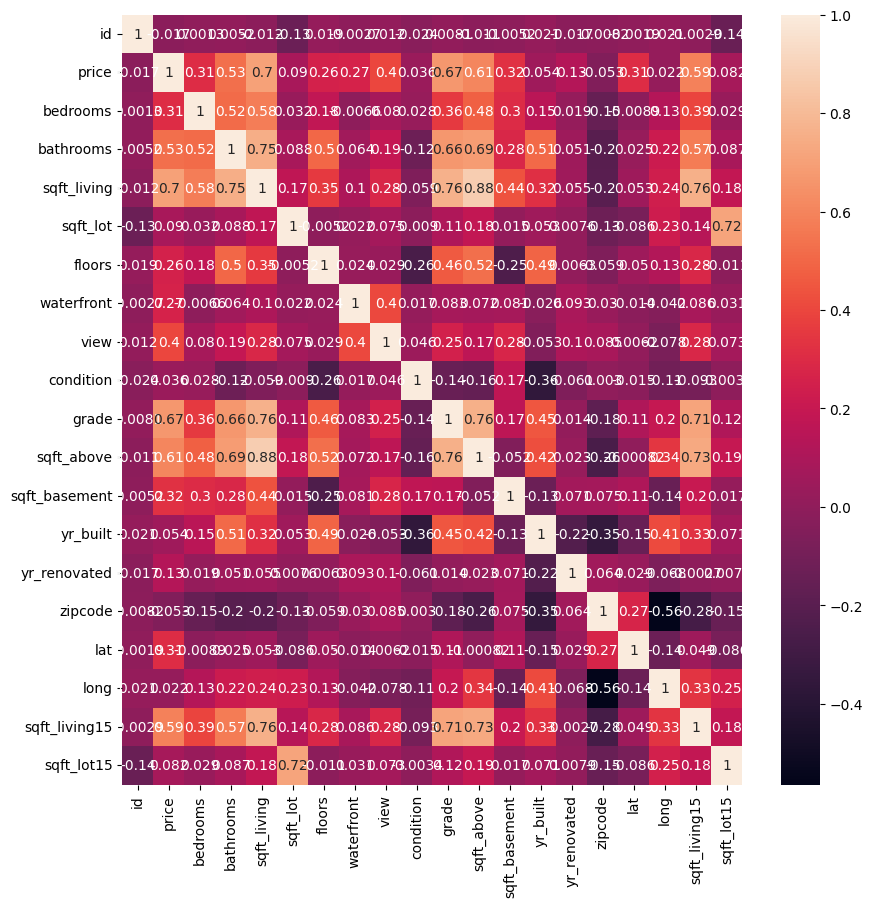

In [4]:
figura = plt.figure(figsize=(20,20))
sns.heatmap(base_casas.corr(), annot= True)

# Pré Processamento

In [5]:
base_casas.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
# da coluna Bedrooms até Long - .values para transformar no formato do numpy
X = base_casas.iloc[:, 2:18].values
X[0]

In [12]:
Y = base_casas.iloc[:, 1]

(21613,)

Dados estao no formato de vetor, mas é necessario mandar para AWS em formato de matriz. Necessarior realizar a conversao 

In [30]:
X = np.array(X).astype('float32')
Y = np.array(Y).astype('float32')

Divisao entre: Porção de treinamento x Porção de testagem 

In [34]:
from sklearn.model_selection import train_test_split
# Teste = 30% - Treinamento = 70%
X_treinamento, X_teste, Y_treinamento, Y_teste = train_test_split(X, Y, test_size=0.3, random_state=0)

In [38]:
X_treinamento.shape, X_teste.shape, Y_treinamento.shape, Y_teste.shape

((15129, 16), (6484, 16), (15129,), (6484,))

# Configurações SageMaker

In [25]:
import sagemaker
import boto3
from sagemaker import Session

session = sagemaker.Session() # Iniciando session

bucket = 'sagemaker-curso-bucket' # Bucket S3
subpasta_modelo = 'modelos/house-prices/linear-learner'
subpasta_dataset = 'datasets/house-prices'


In [26]:
# Ao criar o ambiente no sagemaker, criamos essas regras
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::339712791663:role/aws-reserved/sso.amazonaws.com/AWSReservedSSO_AdministratorAccess_9cd520d2a762008d


In [37]:
import io
import sagemaker.amazon.common as smac # sagemaker commom library



buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X_treinamento, Y_treinamento) # convertendo numpy to aws format
buffer.seek(0)

0

Upload para o Bucket S3

In [42]:
import os
key = 'houses-train-data'

## os path faz a concatenação do caminho
boto3.resource('s3').Bucket(bucket).Object(os.path.join(subpasta_dataset, 'train', key)).upload_fileobj(buffer)

In [43]:
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, subpasta_dataset, key)
print('Localização da base de treinamento: {}'.format(s3_train_data))

Localização da base de treinamento: s3://sagemaker-curso-bucket/datasets/house-prices/train/houses-train-data


In [44]:
# onde salvar o modelo depois de treinado
output_location = 's3://{}/{}/output'.format(bucket, subpasta_modelo)
print('Modelo será salvo em: {}'.format(output_location))

Modelo será salvo em: s3://sagemaker-curso-bucket/modelos/house-prices/linear-learner/output


# Criação e treinamento do Linear Learner